# STMNet Tutorial

This notebook demonstrates running a simple Spike Template Matching Network (STMNet).
STMNet is implemented using the Lava software framework for neuromorphic computing.
Lava can be downloaded [on github](https://github.com/lava-nc/lava) and the docs can be found at [lava-nc.org](https://lava-nc.org).


In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps

import stmnet.network as network
import stmnet.configuration as config
import stmnet.proc as proc
import stmnet.io as stmio

## Defining the Network

The STMNet requires a Network Description, which defines the architecture of the network.
A network description contains three parts:

- Feature detector key
- Binary detector key
- Spike templates

### Feature detector key

A dict containing integer keys and string values.
The keys define the order of the feature detectors.
The values are the corresponding names of the detectors.

### Binary detector key

A dict containing integer keys and string values.
The keys define the order of the binary detectors.
The values are the corresponding names of the detectors.

### Spike Templates

A dict containing the spike sequences.
The keys are the names of the templates.
Each value is a dict containing the keys `onset` and `offset`.
For each key, the corresponding spike template is provided as a list of index, time pairs.
The indices correspond to the keys of the feature detector key.
The times are the spike time for the given detector in the template.


In [2]:
# define network architecture

network_description = network.NetworkDescription(
    feature_detectors={
        0: "a.b-c.0.0.0.0.spectrogram.NoMask",
        1: "a.b-c.0.0.1.0.spectrogram.NoMask",
        2: "a.b-c.0.0.2.0.spectrogram.NoMask",
        3: "a.b-c.0.0.3.0.spectrogram.NoMask",
        4: "a.b-c.0.0.4.0.spectrogram.NoMask",
        5: "b.a-c.0.0.0.0.spectrogram.NoMask",
        6: "b.a-c.0.0.1.0.spectrogram.NoMask",
        7: "b.a-c.0.0.2.0.spectrogram.NoMask",
        8: "b.a-c.0.0.3.0.spectrogram.NoMask",
        9: "c.a-b.0.0.0.0.spectrogram.NoMask"
    },
    binary_detectors={
        0: "a.b.2.0.0.spectrogram.0-0-0-0",
        1: "a.c.2.0.0.spectrogram.0-0-0-0",
        2: "b.c.2.0.0.spectrogram.0-0-0-0"
    },
    templates={
        "a.b-c.0.1": {
            "onset": [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5],],
            "offset": [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5],]
        },
        "a.b-c.0.2": {
            "onset": [[0, 1], [1, 1], [2, 3], [3, 4], [4, 6],],
            "offset": [[0, 1], [1, 1], [2, 3], [3, 4], [4, 6],]
        },
        "b.a-c.0.1": {
            "onset": [[5, 1], [6, 2], [7, 3], [8, 4],],
            "offset": [[5, 1], [6, 2], [7, 3], [8, 4],]
        },
        "b.a-c.0.2": {
            "onset": [[5, 1], [6, 1], [7, 3], [8, 3],],
            "offset": [[5, 1], [6, 1], [7, 3], [8, 3],]
        },
        "c.a-b.0.1": {
            "onset": [[9, 1],],
            "offset": [[9, 1],]
        },
        "c.a-b.0.2": {
            "onset": [[9, 1],],
            "offset": [[9, 1],]
        },
    }
)

We can view the network description using it's `print()` method:

In [3]:
network_description.print()

Network Description
-------------------
Feature Detectors:
   0: a.b-c.0.0.0.0.spectrogram.NoMask
   1: a.b-c.0.0.1.0.spectrogram.NoMask
   2: a.b-c.0.0.2.0.spectrogram.NoMask
   3: a.b-c.0.0.3.0.spectrogram.NoMask
   4: a.b-c.0.0.4.0.spectrogram.NoMask
   5: b.a-c.0.0.0.0.spectrogram.NoMask
   6: b.a-c.0.0.1.0.spectrogram.NoMask
   7: b.a-c.0.0.2.0.spectrogram.NoMask
   8: b.a-c.0.0.3.0.spectrogram.NoMask
   9: c.a-b.0.0.0.0.spectrogram.NoMask
Binary Detectors:
   0: a.b.2.0.0.spectrogram.0-0-0-0
   1: a.c.2.0.0.spectrogram.0-0-0-0
   2: b.c.2.0.0.spectrogram.0-0-0-0
Templates:
  a.b-c.0.1:
     Onset: [0, 1], [1, 2], [2, 3], [3, 4], [4, 5]
    Offset: [0, 1], [1, 2], [2, 3], [3, 4], [4, 5]
  a.b-c.0.2:
     Onset: [0, 1], [1, 1], [2, 3], [3, 4], [4, 6]
    Offset: [0, 1], [1, 1], [2, 3], [3, 4], [4, 6]
  b.a-c.0.1:
     Onset: [5, 1], [6, 2], [7, 3], [8, 4]
    Offset: [5, 1], [6, 2], [7, 3], [8, 4]
  b.a-c.0.2:
     Onset: [5, 1], [6, 1], [7, 3], [8, 3]
    Offset: [5, 1], [6, 1], [

## Defining the Input

The spike input defines the data which will be run through the STMNet during recogntion.
The Lava CPU code is built using RingBuffers for the input, storing the spikes as NumPy arrays where
$$
s[i, t] = \{ 1 \textrm{ if input i has spike at time t, else } 0\}.
$$

However, it is much more convenient to think of the spike input as a dictionary containing lists of spike times for each input.
This can then be converted to the spike array when needed.
Remember that each input needs a spike time list for both `onset` and `offset` spikes.

We also will need to provide the number of timesteps for the network to run.

The `input_key` is used to map the feature and binary inputs to the appropriate templates / neurons.
The current setup assumes that templates have names of the form `{a}.{other-stuff}`,
where 'a' is the category it recognizes.
The feature detectors are named similarly, with the corresponding category of he feature.
The binary detectors are named `{a}.{b}.{other-stuff}`, signifying the detector is trained to recognize category 'a' and not category 'b'.

In [4]:
# binary detectors only need onset
input_spikes = {
    "onset": {
        0: [11, 51],
        1: [12, 52],
        2: [13, 53],
        3: [14, 54],
        4: [15, 55],
        5: [26, 51],
        6: [27, 52],
        7: [28, 53],
        8: [29, 54],
        9: [45],
        10: [11, 13, 15, 16, 19, 21, 51, 53, 55, 56, 59, 61],
        11: [26, 28, 30, 31, 33],
        12: [1, 2, 3, 5, 8, 13, 21, 46]
    },
    "offset": {
        0: [21, 61],
        1: [22, 62],
        2: [23, 63],
        3: [24, 64],
        4: [25, 65],
        5: [36, 61],
        6: [37, 62],
        7: [39, 63],
        8: [39, 64],
        9: [47],
    },
    "detector_names": [
        "a.b-c.0.0.0.0.spectrogram.NoMask",
        "a.b-c.0.0.1.0.spectrogram.NoMask",
        "a.b-c.0.0.2.0.spectrogram.NoMask",
        "a.b-c.0.0.3.0.spectrogram.NoMask",
        "a.b-c.0.0.4.0.spectrogram.NoMask",
        "b.a-c.0.0.0.0.spectrogram.NoMask",
        "b.a-c.0.0.1.0.spectrogram.NoMask",
        "b.a-c.0.0.2.0.spectrogram.NoMask",
        "b.a-c.0.0.3.0.spectrogram.NoMask",
        "c.a-b.0.0.0.0.spectrogram.NoMask",
        "a.b.2.0.0.spectrogram.0-0-0-0",
        "a.c.2.0.0.spectrogram.0-0-0-0",
        "b.c.2.0.0.spectrogram.0-0-0-0"
    ]
}

input_key = (
    [det.split('.')[0] for det in network_description.feature_detectors.values()]
    + [
        '.'.join(det.split('.')[0:2])
        for det in network_description.binary_detectors.values()
    ]
)


n_timesteps = 70

# Building the Network

In order to build the network, we must also provide a config.
This config defines the various parameters of the network.
For the demo, we will use the default parameters provided with `stmnet`.

In [5]:
# use the default configuration
cfg = config.default_tmn_config()

In [6]:
# build the base template matching network
stmnet = network.TemplateMatchingNetwork(
    network_description.feature_detectors,
    network_description.templates,
    network_description.binary_detectors,
    cfg
)

stmnet.build_network()

In [7]:
# add the binary module
bpn = network.BinaryPredictionNetwork(
    list(network_description.templates),
    list(network_description.binary_detectors.values()),
    cfg,
    stmnet.max_onset_delay
)

bpn.build_network()
bpn.connect_to_template_matching_network(stmnet)


In [8]:
# set up the inputs
n_inputs = {
    "onset": (
        len(network_description.feature_ids)
        + len(network_description.binary_ids)
    ),
    "offset": len(network_description.feature_ids)
}
runtime = n_timesteps + cfg.meta.runtime_buffer

input_arrs = {
    "onset": np.zeros(shape=(n_inputs["onset"], runtime)),
    "offset": np.zeros(shape=(n_inputs["offset"], runtime))
}
for onoff in ["onset", "offset"]:
    for feat_idx, feat_spikes in input_spikes[onoff].items():
        for time in feat_spikes:
            input_arrs[onoff][feat_idx, time] = 1

# create Lava spike inputs
spike_generators = {}
spike_generators["onset"] = stmio.SpikeInputLayer(data=input_arrs["onset"])
spike_generators["offset"] = stmio.SpikeInputLayer(data=input_arrs["offset"])


In [9]:
# set up the output
spike_receiver = proc.SpikeOut(
    shape=stmnet.DecisionLayer.s_out.shape,
    buffer=runtime
)

In [10]:
# connect IO to the network
for onoff in ["onset", "offset"]:
    stmnet.connect_input_layer(spike_generators[onoff].s_out, onoff)
    stmnet.connect_output_layer(spike_receiver.a_in)
bpn.connect_to_input_layer(spike_generators, input_key)

## Running the Network

With the network built, we can now run it like any other Lava network.
We will use the `Loihi2SimCfg` to run the network on a CPU.

In [11]:
spike_generators["onset"].run(
    RunSteps(num_steps=runtime),
    run_cfg=Loihi2SimCfg(
        loglevel=logging.INFO,
        select_tag="fixed_pt"
    ),
)

decision_data = spike_receiver.data.get()

spike_generators["onset"].stop()

## Plotting the Results

We can see that the output spike pattern correctly identifies the input, "a, b, c, a".
On the second occurrence of "a", the binary detectors resolve the confusion between "a" and "b".

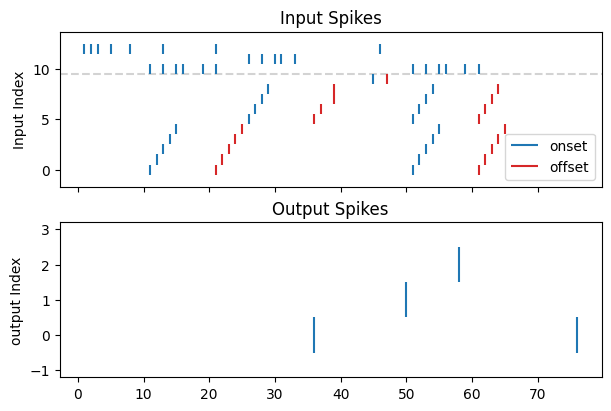

In [12]:
# create output raster
decision_raster = [
    np.nonzero(row)[0] for row in decision_data
]

# plot the inputs and outputs together
fig, axs = plt.subplots(
    2, 1, figsize=(6, 4), sharex=True, layout="constrained"
)

ax: plt.Axes = axs[0]
ax.set_title("Input Spikes")
ax.set_ylabel("Input Index")
ax.axhline(
    y=len(network_description.feature_ids) - 0.5,
    color="lightgray", linestyle="dashed"
)
_on = ax.eventplot(list(input_spikes["onset"].values()), label="onset")
_off = ax.eventplot(
    list(input_spikes["offset"].values()), label="offset", color="tab:red"
)
ax.legend(
    [_on[0], _off[0]], [_on[0].get_label(), _off[0].get_label()],
    loc="lower right"
)

ax = axs[1]
ax.set_title("Output Spikes")
ax.set_ylabel("output Index")
ax.eventplot(decision_raster)

plt.show()